In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from warnings import filterwarnings
filterwarnings(action="ignore")

In [125]:
r2 = lambda x:round(x * 100,2)

In [126]:
class ClassificationSummary:
    
    def __init__(self, y_true: np.array ,y_pred: np.array):
        
        self.__y_true: array = y_true
        self.__y_pred: array = y_pred
        self.__confusion_matrix: np.ndarray
        self.__sensitivity: float
        self.__specificity: float
        self.__accuracy: float
        self.missclassification_error: float
        self.__recall_score: float
        self.__precision_score: float
        self.__summary_data()
    
    @property
    def y_true(self):
        return self.__y_true
    
    @property
    def y_pred(self):
        return self.__y_pred
    
    @property
    def confusion_matrix(self):
        return self.__confusion_matrix
    
    @property
    def sensitivity(self):
        return self.__sensitivity
    
    @property
    def specificity(self):
        return self.__specificity
    
    @property
    def accuracy(self):
        return self.__accuracy

    @property
    def recall_score(self):
        return self.__recall_score
    
    @property
    def precision_score(self):
        return self.__precision_score
    
    @property
    def missclassification_error(self):
        return self.__missclassification_error
    
    def __summary_data(self):
        self.__confusion_matrix = sklearn.metrics.confusion_matrix(self.__y_true, self.__y_pred)
        tn, fp, fn, tp = self.__confusion_matrix.ravel()
        self.__sensitivity: float = tp / (tp + fn)
        self.__specificity: float = tn / (tn + fp)
        self.__accuracy: float = (tn + tp) / (tn + fp + fn + tp)
        self.__missclassification_error: float = 1 - self.__accuracy
        self.__recall_score = sklearn.metrics.recall_score(self.__y_true, self.__y_pred)
        self.__precision_score = sklearn.metrics.precision_score(self.__y_true, self.__y_pred)
            
    def __repr__(self):

        r2 = lambda x: round(x * 100,2)
        
        return(
                "Confusion Matrix:\n{}".format(self.__confusion_matrix)
               +"\n"
               +"Accuracy: {}%".format(r2(self.__accuracy))
               +"\n"
               +"Missclassification Error: {}%".format(r2(self.__missclassification_error))
               +"\n"
               +"Sensitivity: {}%".format(r2(self.__sensitivity))
               +"\n"
               +"Specificity: {}%".format(r2(self.__specificity))
               +"\n"
               +"Recall Score: {}%".format(r2(self.__recall_score))
               +"\n"
               +"Precision Score: {}%".format(r2(self.__precision_score))
              )
              

In [127]:
# Import data
text_data = pd.read_csv("spam.csv")

In [128]:
text_data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [129]:
# inspect dataframe

text_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [130]:
# check the sum of null values per feature

text_data.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [131]:
# only select columns with no null values

text_data = text_data.iloc[:,0:2]

In [132]:
text_data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [133]:
class_count = text_data["v1"].value_counts(sort=True)

In [134]:
class_count.index

Index(['ham', 'spam'], dtype='object')

In [135]:
# Count of ham and spam emails
class_count.values

array([4825,  747])

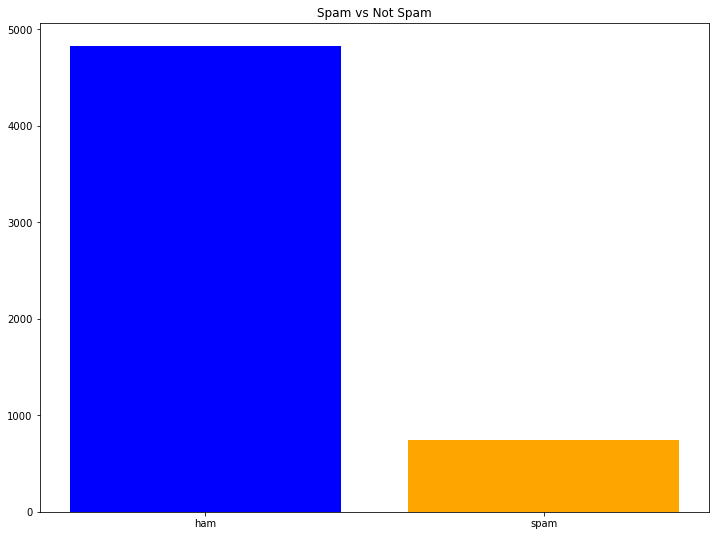

In [136]:
plt.figure(figsize=(12,9))
plt.bar(data=class_count,x=class_count.index,height=class_count.values, color=["blue","orange"])
plt.title("Spam vs Not Spam")
plt.show()

# Text Analytics

- Need to find the frequency of words in both classes of spam (1) and not spam (0) messages.
- The words of the messages will be model features.
- Identifying stop words will be our first challenge
- Stop words are filler words like to, the, and, etc
- There is not a distinct count of stop words

In [137]:
# select the messages classified as non-spam

nonSpamMsg = text_data[text_data.v1 == "ham"]["v2"]

In [138]:
nonSpamMsg.head()

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
6    Even my brother is not like to speak with me. ...
Name: v2, dtype: object

In [139]:
# separate all the words in a feature vector into a giant list
# ensure that the list of words is lower case to combine like words
# separated by each word which is the default of None

allNonSpamWords = " ".join(nonSpamMsg).lower().split(sep = None)
len(allNonSpamWords)

68518

In [140]:
# Top 20 most common used words
mostCommonNonSpamWords = Counter(allNonSpamWords).most_common(20)

In [141]:
spamMsg = text_data[text_data.v1 == "spam"]["v2"]

In [142]:
allSpamWords = " ".join(spamMsg).lower().split(sep = None)

In [143]:
len(allSpamWords)

17817

In [144]:
mostCommonSpamWords = Counter(allSpamWords).most_common(20)

In [145]:
mostCommonNonSpamWords[:5]

[('i', 2172), ('you', 1665), ('to', 1544), ('the', 1113), ('a', 1046)]

In [146]:
mcns_df = pd.DataFrame.from_dict(mostCommonNonSpamWords)
mcns_df.rename(columns={0 : "Non-spam Words"
                       ,1 : "Count"}
                       ,inplace=True)
mcns_df.head()

,Non-spam Words,Count
0,i,2172
1,you,1665
2,to,1544
3,the,1113
4,a,1046


In [147]:
mcs_df = pd.DataFrame.from_dict(mostCommonSpamWords)
mcs_df.rename(columns={0 : "Spam Words"
                       ,1 : "Count"}
                       ,inplace=True)
mcs_df.head()

,Spam Words,Count
0,to,682
1,a,373
2,call,342
3,your,263
4,you,252


In [148]:
mcs_df["Spam Words"].unique()

array(['to', 'a', 'call', 'your', 'you', 'the', 'for', 'or', 'free', '2',
       'is', 'ur', 'on', 'txt', 'have', 'from', 'and', 'u', 'text',
       'mobile'], dtype=object)

In [149]:
mcns_df["Non-spam Words"].unique()

array(['i', 'you', 'to', 'the', 'a', 'u', 'and', 'in', 'my', 'is', 'me',
       'of', 'for', 'that', 'it', 'have', 'your', 'but', 'are', 'so'],
      dtype=object)

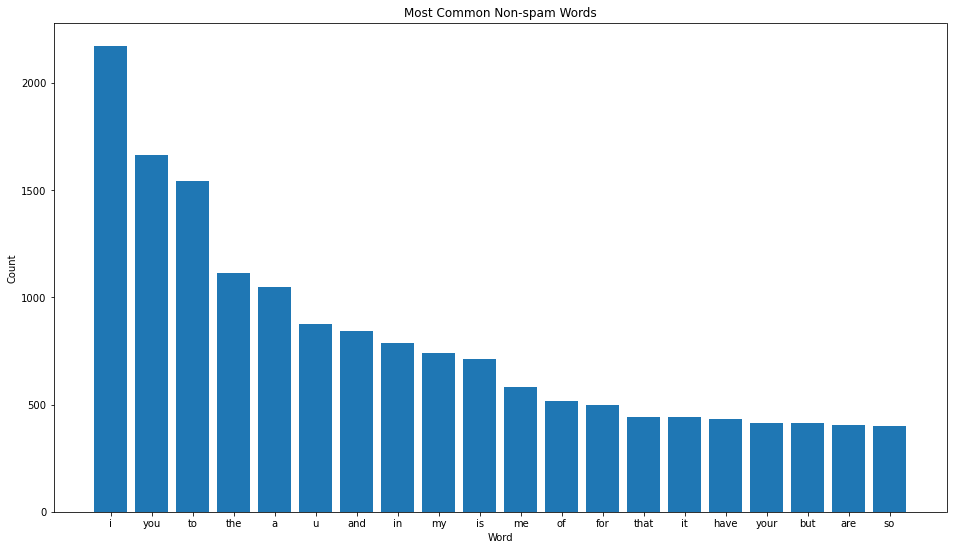

In [150]:
plt.figure(figsize=(16,9))
plt.bar(data=mcns_df, x="Non-spam Words", height=mcns_df.Count)
plt.title("Most Common Non-spam Words")
plt.xlabel("Word")
plt.ylabel("Count")
plt.show()

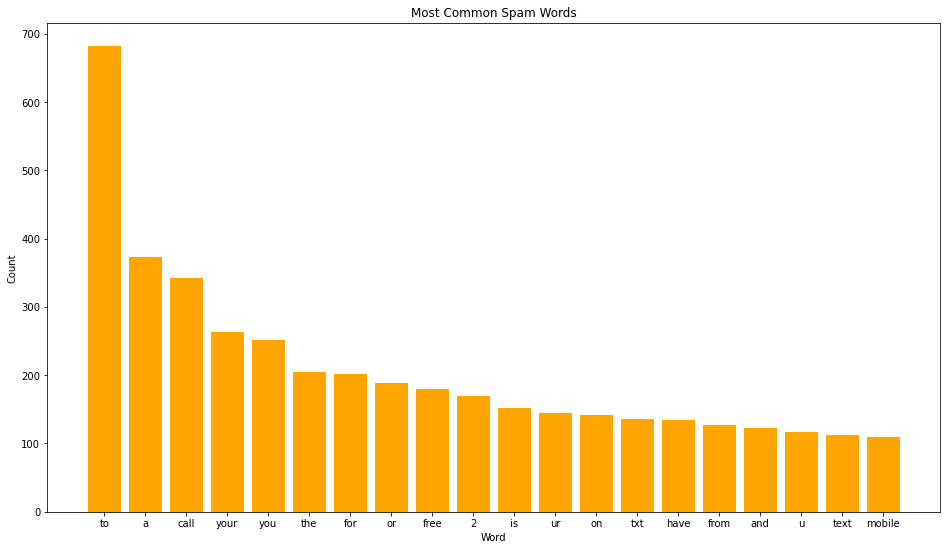

In [151]:
plt.figure(figsize=(16,9))
plt.bar(data=mcs_df, x="Spam Words", height=mcs_df.Count, color="orange")
plt.title("Most Common Spam Words")
plt.xlabel("Word")
plt.ylabel("Count")
plt.show()

# Feature Extraction

- Transform abitrary data like documents, texts and images into usable features for machine learning algorithms

In [152]:
# Transform class values ham and spam into binary variables 0 and 1 respectively

text_data["v1"] = text_data["v1"].replace({"ham":0
                                          ,"spam":1})

In [153]:
# There are problems when using the stop_words parameter and english
# you may want to create your own stop word list at times depending on the problem at hand

fe = CountVectorizer(stop_words="english")

In [154]:
# fit followed by transform with a better implementation
# Create a matrix of featurees

X = fe.fit_transform(text_data.v2)
y = text_data.v1.values

In [155]:
print(X.shape,"\n",y.shape)

(5572, 8357) 
 (5572,)


# Multinomial Naive Bayes

- The Multinomial Naive Bayes classifier is best used with discrete features like word count for text classification

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=9)

In [157]:
mnb_classifier = MultinomialNB()

In [158]:
mnb_classifier.fit(X_train, y_train)

MultinomialNB()

In [159]:
ypred = mnb_classifier.predict(X_test)

In [160]:
cs1 = ClassificationSummary(y_test,ypred)

In [161]:
cs1

Confusion Matrix:
[[1219   24]
 [   7  143]]
Accuracy: 97.77%
Missclassification Error: 2.23%
Sensitivity: 95.33%
Specificity: 98.07%
Recall Score: 95.33%
Precision Score: 85.63%

In [162]:
cs1.confusion_matrix

array([[1219,   24],
       [   7,  143]])

In [163]:
training_score = mnb_classifier.score(X_train,y_train)
print("Training Data ACC: {}%".format(r2(training_score)))


Training Data ACC: 99.5%


In [164]:
testing_score = mnb_classifier.score(X_test,y_test)
print("Testing Data ACC: {}%".format(r2(testing_score)))

Testing Data ACC: 97.77%


In [165]:
r2(metrics.precision_score(y_test,ypred))

85.63

In [166]:
r2(metrics.recall_score(y_test,ypred))

95.33

# Multinomial Naive Bayes - Regularization Parameter Tuning
- Iterate through diffrent values of alpha to find the best value of alpha
- train score
- test score
- recall score
- precision score

In [167]:
alpha = np.arange(1/10000,20,.10)
train_score = np.zeros(len(alpha))
test_score = np.zeros(len(alpha))
recall_score = np.zeros(len(alpha))
precision_score = np.zeros(len(alpha))

In [168]:
train_score[0]

0.0

In [169]:
i = 0

for a in alpha:
    mnb_classifier = MultinomialNB(alpha=a)
    mnb_classifier.fit(X_train,y_train)
    train_score[i] = mnb_classifier.score(X_train, y_train)
    test_score[i] = mnb_classifier.score(X_test, y_test)
    recall_score[i] = metrics.recall_score(y_test,mnb_classifier.predict(X_test))
    precision_score[i] = metrics.precision_score(y_test,mnb_classifier.predict(X_test))
    i+=1

In [170]:
train_score[:5]

array([0.99736779, 0.99641062, 0.99617133, 0.99664992, 0.99664992])

In [171]:
 # takes a row vector transforms it to a column vector
np.c_[train_score[:5]]

array([[0.99736779],
       [0.99641062],
       [0.99617133],
       [0.99664992],
       [0.99664992]])

In [172]:
acc_results = np.matrix(np.c_[alpha,train_score,test_score,recall_score,precision_score])

In [173]:
models = pd.DataFrame(data=acc_results
            ,columns=["Alpha"
                     ,"Train ACC"
                     ,"Test ACC"
                     ,"Recall Score"
                     ,"Precision Score"])

In [174]:
models.head(10)

,Alpha,Train ACC,Test ACC,Recall Score,Precision Score
0,0.0001,0.997368,0.979182,0.960000,0.862275
1,0.1001,0.996411,0.977028,0.973333,0.839080
2,0.2001,0.996171,0.979182,0.966667,0.857988
3,0.3001,0.996650,0.978464,0.973333,0.848837
4,0.4001,0.996650,0.977746,0.973333,0.843931
5,0.5001,0.995693,0.977028,0.973333,0.839080
6,0.6001,0.995693,0.977028,0.966667,0.843023
7,0.7001,0.995214,0.977028,0.966667,0.843023
8,0.8001,0.995214,0.976310,0.960000,0.842105
9,0.9001,0.995214,0.977028,0.953333,0.851190


# Sensitivity Specificity Trade-Off
## Choose The Best Model that Generates The Least Amount of False Positives

- As having the best of both worlds is ideal we tend to predict on one side or the other more often than not
- We need to decide if we want to reduce false positives or false negatives
- In the case of spam classification what does this mean?
    - False Positives will classify Non-spam as spam
    - False Negatives will classify spam as non-spam
- If the former happens then we will most likely never see the message
- if the latter happens we will just have to delete the spam message
- So we need less false positives or a high (Specificity / Precision)
- Highest precision score
- precision is intuitively the ability of the classifier not to label as positive a sample that is negative

In [175]:
models[models["Precision Score"] == 1].head(3)

,Alpha,Train ACC,Test ACC,Recall Score,Precision Score
144,14.4001,0.979182,0.982053,0.833333,1.0
145,14.5001,0.979182,0.982053,0.833333,1.0
146,14.6001,0.979182,0.982053,0.833333,1.0


# Multinomial Naive Bayes - With Best Regularization Parameter

- As having the best of both worlds is ideal we tend to predict on one side or the other more often than not
- We need to decide if we want to reduce false positives or false negatives
- In the case of spam classification what does this mean?
    - False Positives will classify Non-spam as spam
    - False Negatives will classify spam as non-spam
- If the former happens then we will most likely never see the message
- if the latter happens we will just have to delete the spam message
- So we need less false positives or a high (Specificity / Precision)

In [176]:
mnb_classifier = MultinomialNB(alpha=14.4)

In [177]:
mnb_classifier.fit(X_train,y_train)

MultinomialNB(alpha=14.4)

In [178]:
ypred = mnb_classifier.predict(X_test)

In [179]:
cs2 = ClassificationSummary(y_test,ypred)

In [180]:
cs2

Confusion Matrix:
[[1243    0]
 [  25  125]]
Accuracy: 98.21%
Missclassification Error: 1.79%
Sensitivity: 83.33%
Specificity: 100.0%
Recall Score: 83.33%
Precision Score: 100.0%

We classified 25 emails as spam that were ham and 0 ham emails were classified as spam